# Import des librairies

In [ ]:
import cv2

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

from PIL import Image

import random

import seaborn as sns

import shutil

import time,datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from torchsummary import summary

from tqdm.autonotebook import tqdm

import sklearn.metrics as metrics

torch.cuda.empty_cache()
print(torch.cuda.is_available())
print(torch.__version__)
! nvidia-smi

# Extraction des données

In [ ]:
!tar -xzvf ../data/archive.tar.gz --warning=no-unknown-keyword --exclude='._*' --exclude='.DS_Store'  -C ../data/

# Préparation des données d'entrainement, de validation et de test

In [164]:
class_names = ['normal', 'viral', 'covid']
root_dir = '../data/xrays_dataset'
source_dirs = ['Normal/images', 'Pneumonia/images', 'COVID/images']

test_ratio = 0.1
val_ratio = 0.1

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join('../data', 'train'))
    os.mkdir(os.path.join('../data', 'val'))
    os.mkdir(os.path.join('../data', 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join('../data', 'train',  class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join('../data', 'test', c))
        os.mkdir(os.path.join('../data', 'val', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join('../data', 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images)*test_ratio))
        for image in selected_images:
            source_path = os.path.join('../data', 'train', c, image)
            target_path = os.path.join('../data', 'test', c, image)
            shutil.move(source_path, target_path)
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join('../data', 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images)*val_ratio))
        for image in selected_images:
            source_path = os.path.join('../data', 'train', c, image)
            target_path = os.path.join('../data', 'val', c, image)
            shutil.move(source_path, target_path) 

root_dir = '../data'

# Création de la classe de Dataset

In [165]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names =  ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        img = Image.open(image_path).convert('RGB')
        # Converting from PIL image to numpy array
        data = np.asarray(img)
        # Performing a Contrast Stretching in each image from the Dataset
        hist,bins = np.histogram(data.flatten(),256,[0,256])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()
        cdf_m = np.ma.masked_equal(cdf,0)
        cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
        cdf = np.ma.filled(cdf_m,0).astype('uint8')
        # Converting back to PIL image
        image = Image.fromarray(cdf[img])
        
        return self.transform(image), self.class_names.index(class_name)

# Transformation et augmentation des images

In [166]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Préparation des DataLoader

In [167]:
train_path = os.path.join(root_dir, 'train')

train_dirs = {
    'normal': os.path.join(train_path, 'normal'),
    'viral': os.path.join(train_path, 'viral'),
    'covid': os.path.join(train_path, 'covid')
}

train_dataset = CustomDataset(train_dirs, train_transform)

Found 8256 normal examples
Found 1090 viral examples
Found 2930 covid examples


In [168]:
val_path = os.path.join(root_dir, 'val')

val_dirs = {
    'normal': os.path.join(val_path, 'normal'),
    'viral': os.path.join(val_path, 'viral'),
    'covid': os.path.join(val_path, 'covid')
}

val_dataset = CustomDataset(val_dirs, val_transform)

Found 917 normal examples
Found 121 viral examples
Found 325 covid examples


In [169]:
test_path = os.path.join(root_dir, 'test')

test_dirs = {
    'normal': os.path.join(test_path, 'normal'),
    'viral': os.path.join(test_path, 'viral'),
    'covid': os.path.join(test_path, 'covid')
}

test_dataset = CustomDataset(test_dirs, test_transform)

Found 1019 normal examples
Found 134 viral examples
Found 361 covid examples


In [170]:
batch_size = 64

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Distribution des données

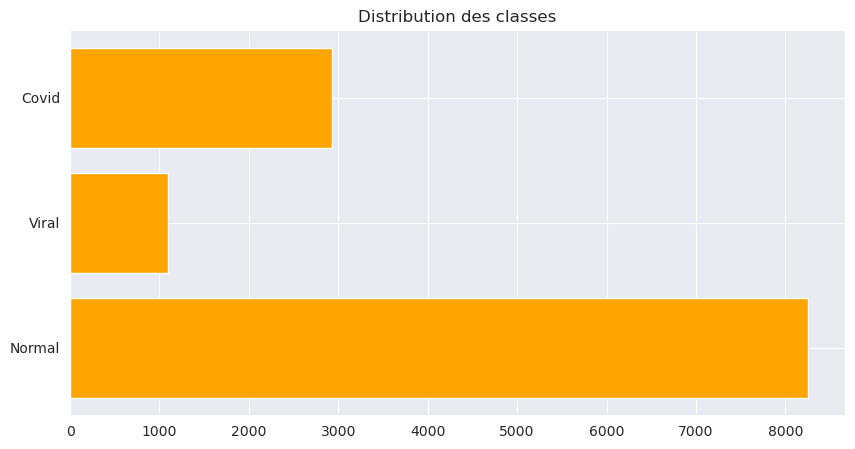

In [171]:
dist = {}
quant = {}
        
for class_name in class_names:
    quant[class_name] = [x for x in os.listdir(train_dirs[class_name]) if x[-3:].lower().endswith('png')]
    dist[class_name.replace('_', ' ').capitalize()] = len(quant[class_name])

courses = list(dist.keys())
values = list(dist.values())
  
fig = plt.figure(figsize=(10, 5))
plt.barh(courses, values, color='orange')

plt.title("Distribution des classes")
plt.show()

# Visualisation des données

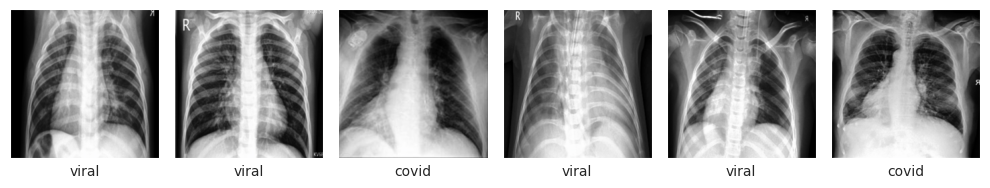

In [172]:
class_names = train_dataset.class_names

def show_images(images, labels):
    plt.figure(figsize=(10,10))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'orange'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
    plt.tight_layout()
    plt.show()
  
images, labels = next(iter(dl_train))
images = images[:6]
show_images(images, labels)

# Création du modèle ResNet

In [173]:
class ResidualBlock(nn.Module):
    """
    Residual Block for the specified ResNet architecture.

    Args:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - stride (int, optional): Stride for the convolutional layers. Defaults to 1.
    """

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection for handling dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        """
        Forward pass through the ResidualBlock.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # If the input channels don't match the output channels after convolutions,
        # apply the shortcut connection to match dimensions
        if self.shortcut:
            residual = self.shortcut(residual)

        out += residual
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    """
    ResNet-18 architecture adapted to the specified layer configuration.

    This ResNet18 model consists of layers designed to match a given architecture.
    """

    def __init__(self):
        super(ResNet18, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual layers using ResidualBlocks
        self.layer1 = self._make_layer(ResidualBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, 2, stride=2)

        # Classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * ResidualBlock.expansion, 3)  # Assuming 3 output classes

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        """
        Create a layer with multiple blocks.

        Args:
        - block (nn.Module): Type of block to be used (e.g., ResidualBlock).
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - num_blocks (int): Number of blocks to be stacked.
        - stride (int): Stride for the first block.

        Returns:
        - nn.Sequential: Sequential layer containing multiple blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, stride))
            in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through ResNet18.

        Args:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def initialize_resnet18():
    """
    Initialize ResNet-18 model.

    Returns:
    - ResNet18: ResNet-18 model instance.
    """
    return ResNet18()

In [174]:
setup = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_model = initialize_resnet18().to(setup)
summary(my_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
     ResidualBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
    ResidualBlock-12         [-1, 64, 224, 224]               0
           Conv2d-13        [-1, 128, 112, 112]          73,728
      BatchNorm2d-14        [-1, 128, 1

# Fonctions d'entrainement et d'évaluation

In [175]:
scores = {'Accuracy': metrics.accuracy_score}
def trainer(model, train_loader, val_loader = None, score_funcs = scores, device = setup, epochs=1, checkpoint_file='../models/resnet.pt'):
  
    loss_func = nn.CrossEntropyLoss()
    
    to_track = ["Epochs", "Time", "Train_Loss"]
    if val_loader is not None:
        to_track.append("Val_Loss")
    for eval_score in score_funcs:
        to_track.append("Train_" + eval_score )
        if val_loader is not None:
            to_track.append("Val_" + eval_score )
        
    total_train_time = 0  
    results = {}
    
    for item in to_track:
        results[item] = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
             
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

          
            optimizer.zero_grad()

            y_hat = model(inputs) 

            
            loss = loss_func(y_hat, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])

        end = time.time()
        total_train_time += (end-start)
        
        results["Epochs"].append( epoch+1 )
        results["Time"].append( str(datetime.timedelta(seconds = total_train_time)) )
        results["Train_Loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: 
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["Train_" + name].append( score_func(y_true, y_pred) * 100)
      
        if val_loader is None:
            pass
        else:
            model = model.eval()

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                running_loss += loss.item() * inputs.size(0)

                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(len(labels)):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["Val_Loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1:
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["Val_" + name].append( score_func(y_true, y_pred) * 100)
                
        if checkpoint_file is not None:
            torch.save({
                'Epochs': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

def evaluator(model,pred_label,true_label,ps_label,dataset,correct,total,accuracy):
    with torch.no_grad():
        for images, labels in dataset:
            model.eval()
            output = model(images.to(setup))
            output = (torch.max(torch.exp(output), 1)[1]).detach().cpu().numpy()
            pred_label.extend(output)
            labels = labels.numpy()
            true_label.extend(labels)
            total += len(labels)
            correct += (output == labels).sum().item()
        accuracy = correct/total
        return pred_label,true_label,ps_label,dataset,correct,total,accuracy

# Entrainement du modèle ResNet

In [176]:
model_results = trainer(my_model, dl_train, val_loader=dl_val)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/192 [00:00<?, ?it/s]

# Résultats de l'entrainement du modèle ResNet

In [ ]:
model_results

,Epochs,Time,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy
0,1,0:02:10.417666,2240.819576,131.124794,92.558651,95.230263
1,2,0:04:23.416411,571.621797,92.216642,98.634531,96.875000
2,3,0:06:32.794027,364.836858,97.504968,98.918622,98.190789
3,4,0:08:42.664074,240.720923,58.312598,99.395161,98.026316
4,5,0:10:53.273412,133.462245,83.265695,99.734238,98.684211
5,6,0:13:05.269695,94.895189,90.846761,99.816716,97.697368
6,7,0:15:16.323597,72.865136,78.098056,99.844208,98.519737
7,8,0:17:26.721750,64.232801,70.193592,99.926686,97.532895
8,9,0:19:38.324814,46.838166,84.500376,99.880865,98.355263
9,10,0:21:49.514170,42.866687,91.052903,99.926686,98.355263


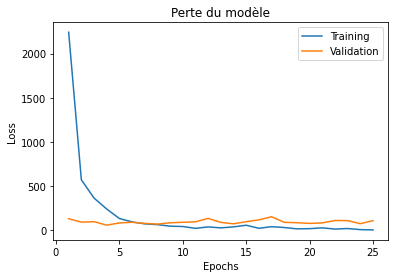

In [ ]:
sns.lineplot(x='Epochs', y='Train_Loss', data=model_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Loss', data=model_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Perte du modèle")
plt.show()

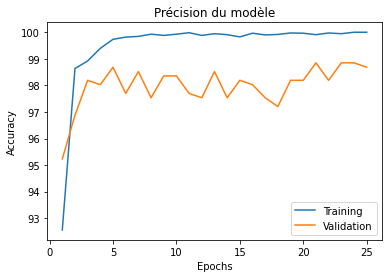

In [ ]:
sns.lineplot(x='Epochs', y='Train_Accuracy', data=model_results, label='Training')
sns.lineplot(x='Epochs', y='Val_Accuracy', data=model_results, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Précision du modèle")
plt.show()

# Évaluation du modèle ResNet18

In [ ]:
test_pred_labels = []
test_true_labels = []
ps_list = []
running_correct = 0.0
running_total = 0.0
accuracy_test=0.0

model_evaluation = evaluator(my_model,test_pred_labels,test_true_labels,ps_list,dl_test,running_correct,running_total,accuracy_test)

In [ ]:
print("Total Correct Images: {} | Total Test Images: {}".format(int(model_evaluation[4]), int(model_evaluation[5])))
print("Test Accuracy: ", model_evaluation[6]*100)

Total Correct Images: 2990 | Total Test Images: 3030
Test Accuracy:  98.67986798679867


In [ ]:
print("Classification report for test set:\n%s\n"
      % (metrics.classification_report(model_evaluation[1], model_evaluation[0],target_names=class_names)))

Classification report for test set:
              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98      1048
   PNEUMONIE       1.00      0.97      0.99       988
    COVID-19       0.99      0.99      0.99       994

    accuracy                           0.99      3030
   macro avg       0.99      0.99      0.99      3030
weighted avg       0.99      0.99      0.99      3030


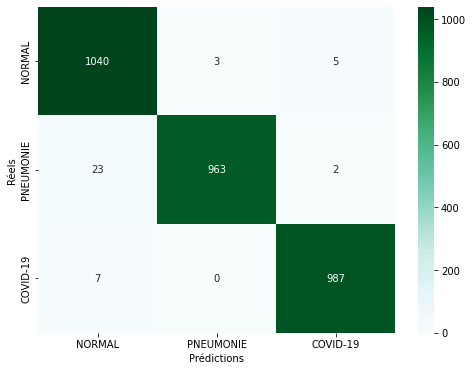

In [ ]:
arr = metrics.confusion_matrix(test_true_labels, test_pred_labels)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Prédictions")
plt.ylabel("Réels")
plt.show()